# Подготовка

### Клонируем nomeroff-net и устанавливаем все необходимые pip зависимости для него.

In [1]:
%%bash

yes | rm -r nomeroff-net
git clone https://github.com/ria-com/nomeroff-net.git
cd nomeroff-net
yes | rm -r .git
pip3 install -r requirements.txt

  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: google-pasta 0.1.5
    Uninstalling google-pasta-0.1.5:
      Successfully uninstalled google-pasta-0.1.5


rm: cannot remove 'nomeroff-net': No such file or directory
Cloning into 'nomeroff-net'...


### Загружаем модель детекта номерных знаков Mask-RCNN

In [2]:
%%bash

cd nomeroff-net/models
wget https://nomeroff.net.ua/models/mrcnn/mask_rcnn_numberplate_0640_2019_06_24.h5

--2019-06-25 14:37:48--  https://nomeroff.net.ua/models/mrcnn/mask_rcnn_numberplate_0640_2019_06_24.h5
Resolving nomeroff.net.ua (nomeroff.net.ua)... 31.28.161.85
Connecting to nomeroff.net.ua (nomeroff.net.ua)|31.28.161.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255858144 (244M) [application/octet-stream]
Saving to: ‘mask_rcnn_numberplate_0640_2019_06_24.h5’

     0K .......... .......... .......... .......... ..........  0% 5.85M 42s
    50K .......... .......... .......... .......... ..........  0% 7.76M 37s
   100K .......... .......... .......... .......... ..........  0% 8.40M 34s
   150K .......... .......... .......... .......... ..........  0% 7.87M 33s
   200K .......... .......... .......... .......... ..........  0% 7.92M 33s
   250K .......... .......... .......... .......... ..........  0% 12.1M 31s
   300K .......... .......... .......... .......... ..........  0% 7.84M 31s
   350K .......... .......... .......... .......... ..........  

### Клонируем Mask-RCNN - модель сегментации.

In [3]:
%%bash

cd nomeroff-net
git clone https://github.com/matterport/Mask_RCNN.git
cd Mask_RCNN
yes | rm -r .git
pip3 install -r requirements.txt

Cloning into 'Mask_RCNN'...


# Смотрим на входные данные.
Название изображения совпадает с самым крупным по полощади номером Грузинских форматов.

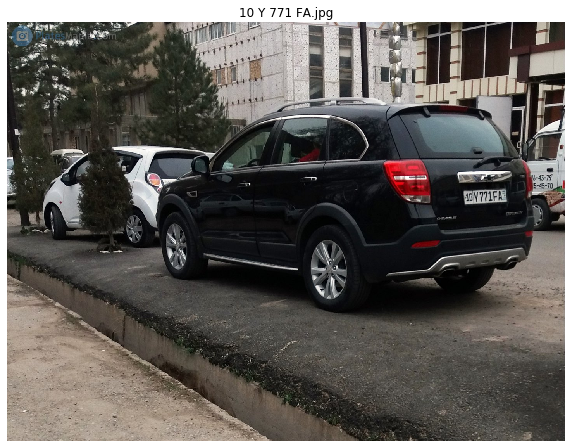

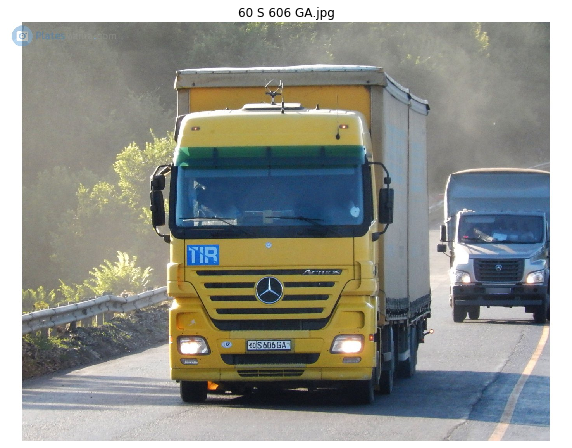

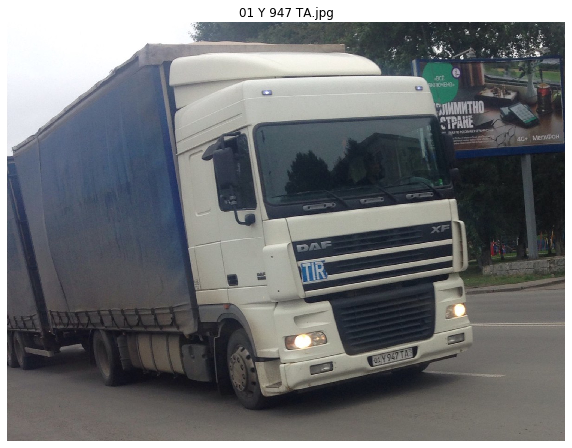

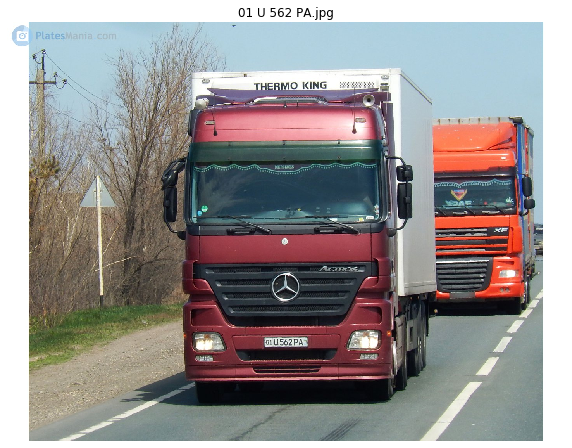

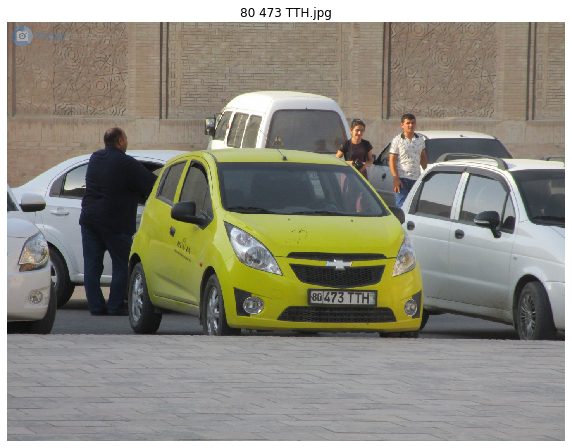

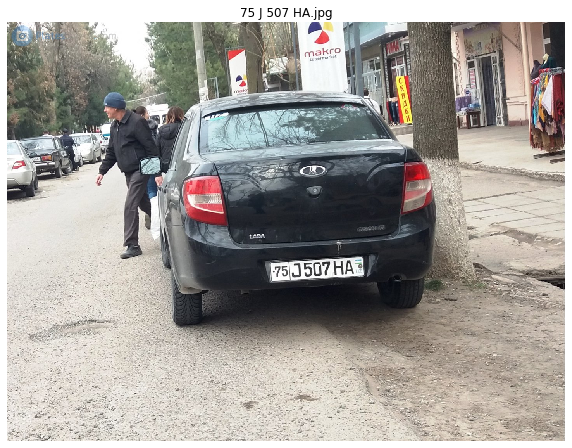

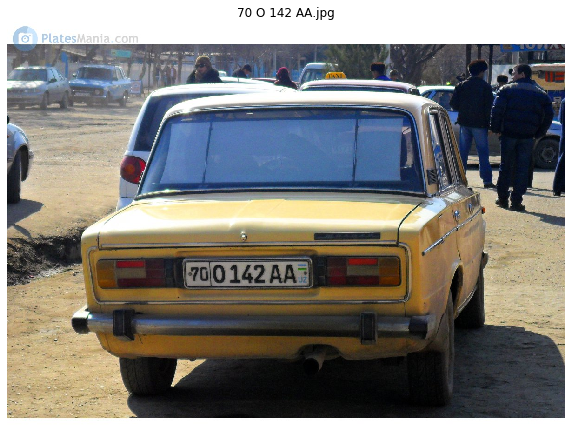

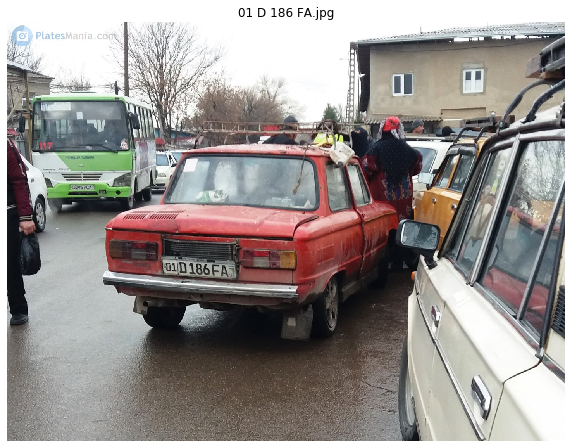

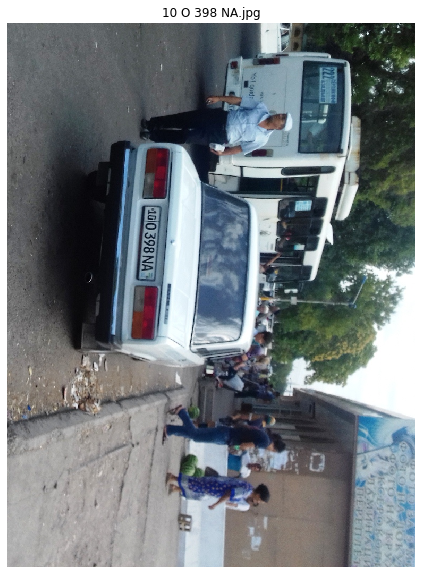

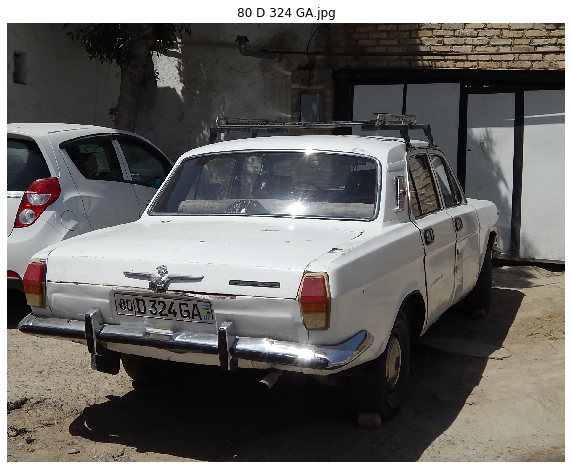

In [41]:
import cv2
from matplotlib import pyplot as plt
import os

for dirpath, dirnames, filenames in os.walk("./images"):
    for photo_path in filenames[:10]:
        img = cv2.imread(os.path.join(dirpath, photo_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)
        ax.set_title(photo_path)
        ax.axis('off')
        plt.show()

### Что бы создать датасет для тренировки OCR вырезаем плашки номерных знаков.

In [29]:
import numpy as np
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

In [30]:
# указываем местоположение номерофф-нет
NOMEROFF_NET_DIR = os.path.abspath('./nomeroff-net')
sys.path.append(NOMEROFF_NET_DIR)

# указываем местоположение маск-рснн
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

# указываем папку для хранения логов мфак-рснн
MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')

# указываем путь к модели детекта плашки номерных знаков
MASK_RCNN_MODEL_PATH = os.path.join(NOMEROFF_NET_DIR, "models/mask_rcnn_numberplate_0640_2019_06_24.h5")

# Импортируем необходимые инструменты для нахождения плашки
from NomeroffNet import  filters, RectDetector, Detector

# Инициализируем инструменты и загружаем модель
nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel(MASK_RCNN_MODEL_PATH)

rectDetector = RectDetector()

In [31]:
async def create_dataset(resultDir, fileList):
    '''
    Функция вырезает номерные плашки из указанного списка файлов fileList, 
    выравнивает их и складывает в папку resultDir,
    а так же создаёт json аннотации к каждому из изображений
    '''
    resultDirAnn = os.path.join(resultDir, "ann")
    
    os.mkdir(resultDirAnn)
    resultDirImg = os.path.join(resultDir, "img")
    os.mkdir(resultDirImg)

    for i, img_path in enumerate(fileList):
        print(i, "/", len(fileList), img_path)

        baseName = os.path.splitext(os.path.basename(img_path))[0]
        orig_name = baseName
        baseName = baseName.split("_")[0].replace(" ", "").replace("-", "")

        img = mpimg.imread(img_path)

        NP = nnet.detect([img])

        # Генерируем маски
        cv_img_masks = await filters.cv_img_mask_async(NP)

        # Находим 4 ключевые точки
        arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=0, fixGeometry=True, fixRectangleAngle=10)

        # Выравниваем перспекивное искажение и вырезаем зоны
        zones = await rectDetector.get_cv_zonesRGB_async(img, arrPoints)

        foundNumber = 0
        for zone in zones:
            res_path_img = os.path.join(resultDirImg, "{}_{}.png".format(baseName, foundNumber))
            res_path_ann = os.path.join(resultDirAnn, "{}_{}.json".format(baseName, foundNumber))
            res_ann = {
                    "orig_name": orig_name,
                    "description": baseName,
                    "name": "{}_{}".format(baseName, foundNumber),
                    "size": {
                        "height": zone.shape[0],
                        "width":  zone.shape[1]
                    }
                }


            if os.path.exists(res_path_img):
                foundNumber += 1
                continue

            # записываем аннотацию
            with open(res_path_ann, "w") as jsonFile:
                json.dump(res_ann, jsonFile)

            # записываем вырезанную плашку
            mpimg.imsave(res_path_img, zone)
            foundNumber += 1

In [32]:
rootDir   = './images'
resultDir = './dataset'

if os.path.exists(resultDir):
    shutil.rmtree(resultDir)
os.mkdir(resultDir)

testSize = 0.2
valSize  = 0.2

X = []
for dirName, subdirList, fileList in os.walk(rootDir):
    for i, fname in enumerate(fileList):
        X.append(os.path.join(dirName, fname))
        
# Разбиваем датасет на 3 выборки: тестовою, ренировочную и валидационную
X_train, X_test = train_test_split(X, test_size=testSize, random_state=20)
X_train, X_val = train_test_split(X_train, test_size=valSize, random_state=4)

for fileList, sub_dir in zip([X_train, X_test, X_val], ["train", "test", "val"]):
    resDir = os.path.join(resultDir, sub_dir)
    os.mkdir(resDir)
    await create_dataset(resDir, fileList)

0 / 2592 ./images/30 X 357 LA.jpg
1 / 2592 ./images/40 A 079 FA.jpg
2 / 2592 ./images/80 R 557 HA.jpg
3 / 2592 ./images/75 H 566 FA.jpg
4 / 2592 ./images/80 B 488 FA.jpg
5 / 2592 ./images/01 D 252 CA.jpg
6 / 2592 ./images/10 097 VSF.jpg
7 / 2592 ./images/30 777 ZAA.jpg
8 / 2592 ./images/50 N 266 KA.jpg
9 / 2592 ./images/01 W 702 SA.jpg
10 / 2592 ./images/50 989 QAA.jpg
11 / 2592 ./images/75 262 NAA.jpg
12 / 2592 ./images/01 126 JFA.jpg
13 / 2592 ./images/90 W 565 GA.jpg
14 / 2592 ./images/80 X 619 KA.jpg
15 / 2592 ./images/10 248 NBA.jpg
16 / 2592 ./images/75 B 306 JA.jpg
17 / 2592 ./images/80 Q 808 CA.jpg
18 / 2592 ./images/40 W 202 FA.jpg
19 / 2592 ./images/10 161 VSF.jpg
20 / 2592 ./images/01 590 NEA.jpg
21 / 2592 ./images/20 G 063 CA.jpg
22 / 2592 ./images/10 G 260 PA.jpg
23 / 2592 ./images/90 P 994 KA_1.jpg
24 / 2592 ./images/70 K 709 AA.jpg
25 / 2592 ./images/90 V 601 JA.jpg
26 / 2592 ./images/20 V 911 BA.jpg
27 / 2592 ./images/60 E 378 FA.jpg
28 / 2592 ./images/75 P 151 EA.jpg
2

232 / 2592 ./images/90 U 391 CA.jpg
233 / 2592 ./images/50 K 022 FA_1.jpg
234 / 2592 ./images/01 224 HEA.jpg
235 / 2592 ./images/70 U 706 JA.jpg
236 / 2592 ./images/01 464 RDA.jpg
237 / 2592 ./images/90 V 540 KA.jpg
238 / 2592 ./images/01 P 981 MA.jpg
239 / 2592 ./images/50 A 042 GA.jpg
240 / 2592 ./images/10 A 002 AA.jpg
241 / 2592 ./images/90 F 048 FA.jpg
242 / 2592 ./images/01 B 808 CA.jpg
243 / 2592 ./images/75 H 416 GA.jpg
244 / 2592 ./images/10 W 761 NA.jpg
245 / 2592 ./images/75 A 102 KA_1.jpg
246 / 2592 ./images/01 N 560 QA.jpg
247 / 2592 ./images/30 G 062 RA.jpg
248 / 2592 ./images/10 186 SAA.jpg
249 / 2592 ./images/01 193 EEA.jpg
250 / 2592 ./images/80 A 506 LA.jpg
251 / 2592 ./images/01 Y 464 UA.jpg
252 / 2592 ./images/80 A 815 LA.jpg
253 / 2592 ./images/30 N 779 BA.jpg
254 / 2592 ./images/40 C 202 EA.jpg
255 / 2592 ./images/10 304 CAA.jpg
256 / 2592 ./images/10 571 TAA.jpg
257 / 2592 ./images/40 W 793 CA.jpg
258 / 2592 ./images/10 214 UAA.jpg
259 / 2592 ./images/70 P 464 GA

461 / 2592 ./images/50 D 240 JA.jpg
462 / 2592 ./images/20 V 284 DA.jpg
463 / 2592 ./images/80 K 467 FA.jpg
464 / 2592 ./images/10 692 RAA.jpg
465 / 2592 ./images/75 T 778 DA.jpg
466 / 2592 ./images/80 O 808 LA.jpg
467 / 2592 ./images/10 249 SAA.jpg
468 / 2592 ./images/01 284 OAA.jpg
469 / 2592 ./images/30 K 361 MA.jpg
470 / 2592 ./images/01 B 415 JA.jpg
471 / 2592 ./images/01 901 ZDF.jpg
472 / 2592 ./images/01 216 EFA.jpg
473 / 2592 ./images/90 U 626 KA.jpg
474 / 2592 ./images/10 H 002498_1.jpg
475 / 2592 ./images/70 M 465 NA.jpg
476 / 2592 ./images/95 G 047 GA.jpg
477 / 2592 ./images/75 B 307 HA.jpg
478 / 2592 ./images/40 O 081 LA.jpg
479 / 2592 ./images/10 335 TTB.jpg
480 / 2592 ./images/95 Z 010 CA_1.jpg
481 / 2592 ./images/90 S 937 CA.jpg
482 / 2592 ./images/40 R 186 HA.jpg
483 / 2592 ./images/01 L 443 BB.jpg
484 / 2592 ./images/40 G 913 AA.jpg
485 / 2592 ./images/10 S 343 FA.jpg
486 / 2592 ./images/01 W 464 GA.jpg
487 / 2592 ./images/10 M 913 NA.jpg
488 / 2592 ./images/10 057 USB

689 / 2592 ./images/01 M 649 SA.jpg
690 / 2592 ./images/10 K 535 CA.jpg
691 / 2592 ./images/50 U 101 FA.jpg
692 / 2592 ./images/01 D 716 FA.jpg
693 / 2592 ./images/10 241 NBA.jpg
694 / 2592 ./images/60 R 353 KA.jpg
695 / 2592 ./images/80 M 526 MA.jpg
696 / 2592 ./images/80 111 AAA.jpg
697 / 2592 ./images/01 B 825 TA.jpg
698 / 2592 ./images/01 149 FFA.jpg
699 / 2592 ./images/50 P 525 EA.jpg
700 / 2592 ./images/90 Z 593 KA_1.jpg
701 / 2592 ./images/85 045 VAA.jpg
702 / 2592 ./images/90 U 192 JA_1.jpg
703 / 2592 ./images/90 O 483 HA.jpg
704 / 2592 ./images/75 C 594 FA.jpg
705 / 2592 ./images/75 R 207 HA_1.jpg
706 / 2592 ./images/70 A 703 EA.jpg
707 / 2592 ./images/80 E 070 DA.jpg
708 / 2592 ./images/85 X 687 FA.jpg
709 / 2592 ./images/10 L 198 RA.jpg
710 / 2592 ./images/75 S 656 HA_1.jpg
711 / 2592 ./images/50 H 167 KA.jpg
712 / 2592 ./images/90 U 525 CA.jpg
713 / 2592 ./images/90 S 443 JA_1.jpg
714 / 2592 ./images/40 966 GAA.jpg
715 / 2592 ./images/90 F 411 FA.jpg
716 / 2592 ./images/20 

917 / 2592 ./images/30 Z 329 DA.jpg
918 / 2592 ./images/01 961 DFA.jpg
919 / 2592 ./images/10 M 735 GA.jpg
920 / 2592 ./images/10 743 RAA.jpg
921 / 2592 ./images/10 Y 675 DA.jpg
922 / 2592 ./images/70 B 259 JA.jpg
923 / 2592 ./images/01 C 171 CA.jpg
924 / 2592 ./images/95 S 737 DA.jpg
925 / 2592 ./images/50 Z 396 LA.jpg
926 / 2592 ./images/01 C 153 EA.jpg
927 / 2592 ./images/80 P 267 JA.jpg
928 / 2592 ./images/80 X 893 CA.jpg
929 / 2592 ./images/40 O 404 HA.jpg
930 / 2592 ./images/40 S 569 LA.jpg
931 / 2592 ./images/01 S 855 VA.jpg
932 / 2592 ./images/50 X 682 GA.jpg
933 / 2592 ./images/20 Y 924 CA.jpg
934 / 2592 ./images/10 498 HAA.jpg
935 / 2592 ./images/75 V 597 FA.jpg
936 / 2592 ./images/01 P 586 GA.jpg
937 / 2592 ./images/01 A 849 CA.jpg
938 / 2592 ./images/60 098 XAA.jpg
939 / 2592 ./images/01 082 SDA.jpg
940 / 2592 ./images/90 W 909 HA.jpg
941 / 2592 ./images/40 203 ABA_1.jpg
942 / 2592 ./images/10 K 845 MA.jpg
943 / 2592 ./images/10 H 595 GA.jpg
944 / 2592 ./images/70 371 TAA.j

1142 / 2592 ./images/80 O 550 BA.jpg
1143 / 2592 ./images/01 R 248 XA.jpg
1144 / 2592 ./images/01 709 VSF.jpg
1145 / 2592 ./images/01 N 841 BB.jpg
1146 / 2592 ./images/30 T 336 HA.jpg
1147 / 2592 ./images/10 369 NBA.jpg
1148 / 2592 ./images/70 R 404 JA.jpg
1149 / 2592 ./images/40 C 110 EA.jpg
1150 / 2592 ./images/10 B 089 QA.jpg
1151 / 2592 ./images/10 R 283 PA.jpg
1152 / 2592 ./images/30 158 TTE.jpg
1153 / 2592 ./images/01 Q 309 VA.jpg
1154 / 2592 ./images/10 943 CAA.jpg
1155 / 2592 ./images/90 025 OAA.jpg
1156 / 2592 ./images/01 712 DXA.jpg
1157 / 2592 ./images/01 T 779 AA.jpg
1158 / 2592 ./images/10 X 424 GA.jpg
1159 / 2592 ./images/80 W 213 LA.jpg
1160 / 2592 ./images/10 B 224 LA.jpg
1161 / 2592 ./images/80 V 645 GA.jpg
1162 / 2592 ./images/75 T 557 JA.jpg
1163 / 2592 ./images/90 P 580 KA.jpg
1164 / 2592 ./images/01 P 975 LA.jpg
1165 / 2592 ./images/90 P 766 KA.jpg
1166 / 2592 ./images/95 Y 057 DA.jpg
1167 / 2592 ./images/10 416 TAA.jpg
1168 / 2592 ./images/40 R 063 RA.jpg
1169 / 2

1365 / 2592 ./images/40 136 UAA.jpg
1366 / 2592 ./images/90 R 409 BA.jpg
1367 / 2592 ./images/01 399 TFA.jpg
1368 / 2592 ./images/10 H 000115.jpg
1369 / 2592 ./images/70 R 199 JA.jpg
1370 / 2592 ./images/01 M 383 OA.jpg
1371 / 2592 ./images/75 V 060 BA.jpg
1372 / 2592 ./images/50 M 150 FA_2.jpg
1373 / 2592 ./images/90 X 363 JA.jpg
1374 / 2592 ./images/01 W 848 UA.jpg
1375 / 2592 ./images/10 C 411 LA.jpg
1376 / 2592 ./images/90 J 156 FA.jpg
1377 / 2592 ./images/60 O 241 GA.jpg
1378 / 2592 ./images/01 019 WEA_1.jpg
1379 / 2592 ./images/10 D 691 LA.jpg
1380 / 2592 ./images/75 R 340 EA_1.jpg
1381 / 2592 ./images/20 D 894 DA.jpg
1382 / 2592 ./images/60 N 904 GA.jpg
1383 / 2592 ./images/30 079 TTH.jpg
1384 / 2592 ./images/50 F 015 LA.jpg
1385 / 2592 ./images/60 840 KAA.jpg
1386 / 2592 ./images/01 U 996 JA.jpg
1387 / 2592 ./images/40 P 470 KA.jpg
1388 / 2592 ./images/90 U 274 GA.jpg
1389 / 2592 ./images/10 Z 613 CA.jpg
1390 / 2592 ./images/10 G 094 BA.jpg
1391 / 2592 ./images/30 J 770 OA.jpg


1587 / 2592 ./images/60 K 491 HA.jpg
1588 / 2592 ./images/50 U 809 LA.jpg
1589 / 2592 ./images/90 T 654 JA.jpg
1590 / 2592 ./images/70 M 024 LA.jpg
1591 / 2592 ./images/75 H 269 JA.jpg
1592 / 2592 ./images/25 212 AAA.jpg
1593 / 2592 ./images/01 707 BFA.jpg
1594 / 2592 ./images/30 O 897 AA.jpg
1595 / 2592 ./images/01 J 409 NA.jpg
1596 / 2592 ./images/95 A 337 FA_1.jpg
1597 / 2592 ./images/30 163 TAA.jpg
1598 / 2592 ./images/01 045 JFA.jpg
1599 / 2592 ./images/01 A 798 RA.jpg
1600 / 2592 ./images/40 Z 953 GA.jpg
1601 / 2592 ./images/01 T 389 EB.jpg
1602 / 2592 ./images/40 H 682 BA.jpg
1603 / 2592 ./images/01 395 AEA.jpg
1604 / 2592 ./images/01 B 417 CB.jpg
1605 / 2592 ./images/75 R 739 EA.jpg
1606 / 2592 ./images/90 S 115 FA.jpg
1607 / 2592 ./images/10 L 441 EA.jpg
1608 / 2592 ./images/80 R 131 KA.jpg
1609 / 2592 ./images/01 C 164 MA.jpg
1610 / 2592 ./images/10 234 RBA.jpg
1611 / 2592 ./images/90 G 160 GA.jpg
1612 / 2592 ./images/90 P 045 AA.jpg
1613 / 2592 ./images/75 K 079 DA.jpg
1614 

1810 / 2592 ./images/10 546 MAA.jpg
1811 / 2592 ./images/90 499 DAA.jpg
1812 / 2592 ./images/60 390 XAA.jpg
1813 / 2592 ./images/40 511 DBA_1.jpg
1814 / 2592 ./images/40 L 451 GA_1.jpg
1815 / 2592 ./images/90 G 468 GA.jpg
1816 / 2592 ./images/30 J 566 HA.jpg
1817 / 2592 ./images/01 Y 533 HA.jpg
1818 / 2592 ./images/40 122 LAA.jpg
1819 / 2592 ./images/75 883 LAA.jpg
1820 / 2592 ./images/50 Y 508 LA.jpg
1821 / 2592 ./images/80 945 MAA.jpg
1822 / 2592 ./images/60 N 677 LA.jpg
1823 / 2592 ./images/90 W 169 GA.jpg
1824 / 2592 ./images/60 871 OAA.jpg
1825 / 2592 ./images/75 R 629 DA.jpg
1826 / 2592 ./images/10 N 970 JA.jpg
1827 / 2592 ./images/30 114 XAA.jpg
1828 / 2592 ./images/10 C 250 FA_1.jpg
1829 / 2592 ./images/01 144 TBA.jpg
1830 / 2592 ./images/10 W 319 NA.jpg
1831 / 2592 ./images/95 A 418 FA.jpg
1832 / 2592 ./images/80 L 676 MA.jpg
1833 / 2592 ./images/01 O 195 TA.jpg
1834 / 2592 ./images/80 704 TTC.jpg
1835 / 2592 ./images/10 U 144 NA.jpg
1836 / 2592 ./images/95 J 778 AA.jpg
1837 /

2033 / 2592 ./images/01 R 081 RA.jpg
2034 / 2592 ./images/10 925 ABA.jpg
2035 / 2592 ./images/80 O 567 KA.jpg
2036 / 2592 ./images/30 J 686 KA.jpg
2037 / 2592 ./images/95 D 043 FA.jpg
2038 / 2592 ./images/30 V 953 FA.jpg
2039 / 2592 ./images/10 D 905 OA.jpg
2040 / 2592 ./images/75 T 213 DA.jpg
2041 / 2592 ./images/01 Z 291 LA.jpg
2042 / 2592 ./images/20 707 QAA.jpg
2043 / 2592 ./images/40 O 214 BA.jpg
2044 / 2592 ./images/80 A 277 FA.jpg
2045 / 2592 ./images/01 658 XCA.jpg
2046 / 2592 ./images/25 K 203 DA.jpg
2047 / 2592 ./images/95 A 738 AA.jpg
2048 / 2592 ./images/10 O 274 JA.jpg
2049 / 2592 ./images/01 H 000888.jpg
2050 / 2592 ./images/01 V 414 SA.jpg
2051 / 2592 ./images/01 W 394 OA.jpg
2052 / 2592 ./images/75 Y 453 GA.jpg
2053 / 2592 ./images/90 Z 989 FA_1.jpg
2054 / 2592 ./images/10 U 126 PA.jpg
2055 / 2592 ./images/80 F 921 LA.jpg
2056 / 2592 ./images/40 A 349 LA.jpg
2057 / 2592 ./images/90 U 197 HA.jpg
2058 / 2592 ./images/40 V 139 HA.jpg
2059 / 2592 ./images/10 R 719 AA.jpg
20

2256 / 2592 ./images/40 C 224 DA.jpg
2257 / 2592 ./images/70 B 740 OA.jpg
2258 / 2592 ./images/75 N 296 HA.jpg
2259 / 2592 ./images/10 507 TTB_1.jpg
2260 / 2592 ./images/10 185 VSF.jpg
2261 / 2592 ./images/01 402 VEA.jpg
2262 / 2592 ./images/80 B 194 FA.jpg
2263 / 2592 ./images/10 S 975 EA.jpg
2264 / 2592 ./images/10 B 309 CA.jpg
2265 / 2592 ./images/80 202 AAA_1.jpg
2266 / 2592 ./images/70 X 303 CA.jpg
2267 / 2592 ./images/01 D 206 DA.jpg
2268 / 2592 ./images/75 K 979 BA.jpg
2269 / 2592 ./images/90 G 614 LA.jpg
2270 / 2592 ./images/01 O 635 DA.jpg
2271 / 2592 ./images/90 G 572 GA.jpg
2272 / 2592 ./images/30 O 417 JA.jpg
2273 / 2592 ./images/95 811 MAA.jpg
2274 / 2592 ./images/75 B 233 DA.jpg
2275 / 2592 ./images/30 E 722 GA.jpg
2276 / 2592 ./images/10 028 JBA.jpg
2277 / 2592 ./images/95 P 611 FA.jpg
2278 / 2592 ./images/40 B 861 KA_1.jpg
2279 / 2592 ./images/60 770 CAA.jpg
2280 / 2592 ./images/01 635 NFA.jpg
2281 / 2592 ./images/80 U 533 DA.jpg
2282 / 2592 ./images/10 X 540 MA.jpg
228

2479 / 2592 ./images/01 R 010 VA.jpg
2480 / 2592 ./images/01 157 ZBA.jpg
2481 / 2592 ./images/10 J 243 MA.jpg
2482 / 2592 ./images/40 O 897 AA.jpg
2483 / 2592 ./images/80 U 801 KA.jpg
2484 / 2592 ./images/40 L 271 JA.jpg
2485 / 2592 ./images/10 Z 172 PA.jpg
2486 / 2592 ./images/25 958 TTC.jpg
2487 / 2592 ./images/75 638 KAA.jpg
2488 / 2592 ./images/30 O 803 KA.jpg
2489 / 2592 ./images/01 N 945 VA.jpg
2490 / 2592 ./images/30 O 531 PA.jpg
2491 / 2592 ./images/30 J 466 CA.jpg
2492 / 2592 ./images/30 973 TTF.jpg
2493 / 2592 ./images/01 B 101 UA.jpg
2494 / 2592 ./images/30 H 261 GA.jpg
2495 / 2592 ./images/60 H 077 DA.jpg
2496 / 2592 ./images/60 Y 892 AA.jpg
2497 / 2592 ./images/30 541 TTC.jpg
2498 / 2592 ./images/10 D 682 OA.jpg
2499 / 2592 ./images/30 B 740 KA.jpg
2500 / 2592 ./images/10 Q 499 DA.jpg
2501 / 2592 ./images/10 408 SBA.jpg
2502 / 2592 ./images/90 D 365 JA.jpg
2503 / 2592 ./images/40 M 505 DA.jpg
2504 / 2592 ./images/10 396 EAA.jpg
2505 / 2592 ./images/01 681 ZDA.jpg
2506 / 25

119 / 811 ./images/40 V 982 PA.jpg
120 / 811 ./images/70 021 AAA.jpg
121 / 811 ./images/01 382 MAA.jpg
122 / 811 ./images/40 099 HAA_1.jpg
123 / 811 ./images/30 269 TTD.jpg
124 / 811 ./images/60 R 916 NA.jpg
125 / 811 ./images/20 318 VSF.jpg
126 / 811 ./images/90 E 503 JA.jpg
127 / 811 ./images/01 R 564 CA.jpg
128 / 811 ./images/90 P 668 CA.jpg
129 / 811 ./images/95 R 501 DA.jpg
130 / 811 ./images/30 J 940 DA.jpg
131 / 811 ./images/10 Q 143 KA.jpg
132 / 811 ./images/50 Z 086 KA_1.jpg
133 / 811 ./images/80 Y 667 FA.jpg
134 / 811 ./images/95 F 841 HA.jpg
135 / 811 ./images/75 E 199 HA.jpg
136 / 811 ./images/40 A 412 CA.jpg
137 / 811 ./images/75 345 EAA.jpg
138 / 811 ./images/40 C 320 GA.jpg
139 / 811 ./images/75 E 591 BA.jpg
140 / 811 ./images/01 742 VSD_1.jpg
141 / 811 ./images/80 093 ZAA.jpg
142 / 811 ./images/10 B 468 JA.jpg
143 / 811 ./images/40 N 549 FA.jpg
144 / 811 ./images/20 P 031 DA.jpg
145 / 811 ./images/95 243 VSF.jpg
146 / 811 ./images/95 F 955 GA.jpg
147 / 811 ./images/95 0

354 / 811 ./images/80 664 TTE.jpg
355 / 811 ./images/60 X 499 BA.jpg
356 / 811 ./images/30 W 005 QA.jpg
357 / 811 ./images/01 140 VSF.jpg
358 / 811 ./images/90 E 420 KA.jpg
359 / 811 ./images/80 W 044 DA.jpg
360 / 811 ./images/80 090 VAA.jpg
361 / 811 ./images/70 489 BAA.jpg
362 / 811 ./images/10 V 764 PA.jpg
363 / 811 ./images/80 288 RAA.jpg
364 / 811 ./images/20 B 168 BA.jpg
365 / 811 ./images/01 V 881 SA.jpg
366 / 811 ./images/90 B 480 KA.jpg
367 / 811 ./images/40 Y 956 EA.jpg
368 / 811 ./images/90 V 849 JA.jpg
369 / 811 ./images/90 C 929 AA_1.jpg
370 / 811 ./images/01 356 HEA.jpg
371 / 811 ./images/50 B 424 FA.jpg
372 / 811 ./images/90 N 554 HA.jpg
373 / 811 ./images/01 621 FCA.jpg
374 / 811 ./images/20 573 MAA.jpg
375 / 811 ./images/30 Y 201 RA.jpg
376 / 811 ./images/01 042 CDA.jpg
377 / 811 ./images/01 916 YBA.jpg
378 / 811 ./images/01 033 ZAA.jpg
379 / 811 ./images/10 M 524 OA.jpg
380 / 811 ./images/40 065 LAA.jpg
381 / 811 ./images/80 H 582 NA.jpg
382 / 811 ./images/10 S 506 NA

590 / 811 ./images/01 103 GFA.jpg
591 / 811 ./images/40 M 230 CA.jpg
592 / 811 ./images/50 Y 860 MA.jpg
593 / 811 ./images/80 T 528 EA.jpg
594 / 811 ./images/50 T 509 EA.jpg
595 / 811 ./images/60 N 253 LA.jpg
596 / 811 ./images/40 L 623 KA.jpg
597 / 811 ./images/90 N 812 KA.jpg
598 / 811 ./images/10 P 514 HA.jpg
599 / 811 ./images/10 040 NAA.jpg
600 / 811 ./images/60 F 117 KA.jpg
601 / 811 ./images/01 P 438 HA.jpg
602 / 811 ./images/01 F 495 FA.jpg
603 / 811 ./images/50 241 EAA.jpg
604 / 811 ./images/50 E 407 KA.jpg
605 / 811 ./images/75 E 181 KA_1.jpg
606 / 811 ./images/01 973 DFA.jpg
607 / 811 ./images/60 W 498 FA.jpg
608 / 811 ./images/90 777 UAA.jpg
609 / 811 ./images/10 C 303 CA.jpg
610 / 811 ./images/30 M 203 AA.jpg
611 / 811 ./images/90 P 070 HA.jpg
612 / 811 ./images/10 U 929 NA.jpg
613 / 811 ./images/75 V 071 JA.jpg
614 / 811 ./images/01 394 LEA.jpg
615 / 811 ./images/10 M 863 HA.jpg
616 / 811 ./images/90 U 310 DA.jpg
617 / 811 ./images/75 O 454 CA.jpg
618 / 811 ./images/10 16

15 / 648 ./images/75 W 275 JA.jpg
16 / 648 ./images/85 121 HAA.jpg
17 / 648 ./images/01 068 SEA.jpg
18 / 648 ./images/01 A 786 SA.jpg
19 / 648 ./images/10 Z 121 EA.jpg
20 / 648 ./images/10 F 506 EA.jpg
21 / 648 ./images/01 G 238 XA.jpg
22 / 648 ./images/01 505 PCA.jpg
23 / 648 ./images/10 484 AAA.jpg
24 / 648 ./images/40 O 799 DA.jpg
25 / 648 ./images/80 774 BAA.jpg
26 / 648 ./images/70 Q 171 KA.jpg
27 / 648 ./images/01 895 NFA.jpg
28 / 648 ./images/60 G 261 AA.jpg
29 / 648 ./images/90 J 687 CA.jpg
30 / 648 ./images/40 R 701 DA.jpg
31 / 648 ./images/10 724 HBA.jpg
32 / 648 ./images/10 235 XAA.jpg
33 / 648 ./images/90 A 234 KA.jpg
34 / 648 ./images/01 906 EBA.jpg
35 / 648 ./images/75 Q 186 HA.jpg
36 / 648 ./images/90 R 580 KA.jpg
37 / 648 ./images/30 296 VAA.jpg
38 / 648 ./images/40 J 140 LA.jpg
39 / 648 ./images/90 J 252 LA.jpg
40 / 648 ./images/10 G 196 KA.jpg
41 / 648 ./images/80 A 363 MA.jpg
42 / 648 ./images/01 N 515 MA.jpg
43 / 648 ./images/75 W 406 EA.jpg
44 / 648 ./images/80 368

253 / 648 ./images/80 U 747 CA.jpg
254 / 648 ./images/20 805 HAA.jpg
255 / 648 ./images/01 132 NEA.jpg
256 / 648 ./images/10 T 945 JA.jpg
257 / 648 ./images/30 Z 909 FA.jpg
258 / 648 ./images/10 H 001101.jpg
259 / 648 ./images/30 F 010 DA.jpg
260 / 648 ./images/01 424 CBA.jpg
261 / 648 ./images/10 817 FAA.jpg
262 / 648 ./images/01 605 VSB.jpg
263 / 648 ./images/10 A 466 HA.jpg
264 / 648 ./images/40 K 402 DA.jpg
265 / 648 ./images/40 C 068 OA.jpg
266 / 648 ./images/75 S 844 GA.jpg
267 / 648 ./images/75 O 621 JA.jpg
268 / 648 ./images/40 Z 830 JA.jpg
269 / 648 ./images/10 350 CAA.jpg
270 / 648 ./images/30 580 TTC.jpg
271 / 648 ./images/40 S 915 OA.jpg
272 / 648 ./images/01 170 RFA.jpg
273 / 648 ./images/80 D 965 GA.jpg
274 / 648 ./images/50 R 846 HA_1.jpg
275 / 648 ./images/01 183 PDA.jpg
276 / 648 ./images/01 T 948 YA.jpg
277 / 648 ./images/10 D 146 HA.jpg
278 / 648 ./images/90 L 655 HA.jpg
279 / 648 ./images/80 M 599 HA.jpg
280 / 648 ./images/10 568 VSF.jpg
281 / 648 ./images/40 670 XA

489 / 648 ./images/80 U 735 KA_1.jpg
490 / 648 ./images/30 V 013 CA.jpg
491 / 648 ./images/25 U 656 EA.jpg
492 / 648 ./images/10 842 DAA.jpg
493 / 648 ./images/30 014 TTF.jpg
494 / 648 ./images/01 J 126 NA.jpg
495 / 648 ./images/01 M 682 TA.jpg
496 / 648 ./images/01 271 VEA.jpg
497 / 648 ./images/10 650 DBA.jpg
498 / 648 ./images/25 G 114 AA.jpg
499 / 648 ./images/10 N 661 HA.jpg
500 / 648 ./images/90 R 453 JA.jpg
501 / 648 ./images/75 W 289 GA.jpg
502 / 648 ./images/01 784 TTD.jpg
503 / 648 ./images/01 J 326 CA.jpg
504 / 648 ./images/60 K 017 GA_1.jpg
505 / 648 ./images/01 K 316 EB.jpg
506 / 648 ./images/01 079 GCA.jpg
507 / 648 ./images/01 P 347 TA.jpg
508 / 648 ./images/75 L 286 JA.jpg
509 / 648 ./images/01 395 LEA.jpg
510 / 648 ./images/10 V 484 GA.jpg
511 / 648 ./images/01 E 672 MA.jpg
512 / 648 ./images/10 Z 452 MA.jpg
513 / 648 ./images/10 H 000203.jpg
514 / 648 ./images/70 C 178 DA.jpg
515 / 648 ./images/50 261 AAA.jpg
516 / 648 ./images/80 K 280 JA.jpg
517 / 648 ./images/50 29

### Тренировка на полученном датасете

In [33]:
# очищаем графф
import keras
keras.backend.clear_session()

In [34]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

DATASET_NAME = "ge"
MODE         = "cpu"

PATH_TO_DATASET   = "dataset"
RESULT_MODEL_PATH = "model.h5"

from NomeroffNet.Base import OCR

In [35]:
class eu(OCR):
    def __init__(self):
        OCR.__init__(self)
        
        # generate automaticly
        #self.letters = ["7"]
        
        self.EPOCHS = 1

In [36]:
ocrTextDetector = eu()
model = ocrTextDetector.prepare(PATH_TO_DATASET, aug_count=0)

GET ALPHABET
Max plate length in "val": 9
Max plate length in "train": 9
Max plate length in "test": 9
Letters train  {'1', 'Q', 'Z', '3', 'R', 'L', 'D', 'S', 'N', '5', 'W', '7', 'V', 'A', 'M', 'O', '8', '9', 'E', '0', 'H', 'Y', 'G', 'K', 'C', '4', 'X', 'B', '6', 'P', 'F', 'T', 'U', 'J', '2'}
Letters val  {'1', 'Q', 'Z', '3', 'R', 'L', 'D', 'S', 'N', '5', 'W', '7', 'A', 'V', 'M', 'O', '9', 'E', 'J', '0', 'H', 'Y', 'G', 'K', 'C', '4', 'X', 'B', '6', 'P', 'F', 'U', 'T', '8', '2'}
Letters test  {'1', 'Q', 'Z', '3', 'R', 'L', 'D', 'S', 'N', '5', 'W', '7', 'V', 'A', 'M', 'O', '8', '9', 'E', '0', 'H', 'Y', 'G', 'K', 'C', '4', 'X', 'B', '6', 'P', 'T', 'F', 'U', 'J', '2'}
Max plate length in train, test and val do match
Letters in train, val and test do match
Letters: 0 1 2 3 4 5 6 7 8 9 A B C D E F G H J K L M N O P Q R S T U V W X Y Z

EXPLAIN DATA TRANSFORMATIONS
eu
Text generator output (data which will be fed into the neutral network):
1) the_input (image)
2) the_labels (plate number): 40

**Примечание:**
На этом этапе могут возникнуть ошибки:
<ul>
   <li><span style="color:red">Max plate length in train, test and val do not match</span> - в одной из выборок(тестовой, валидациоонной или тренировочной) присутствует присутствуют примеры номеров в которых больше символов чем в остальных выборках (нельзя обучив модель находить 8-ми символьные и 7-символьные номера найти 9-ти символьный)</li> 
   <li><span style="color:red">Letters in train, val and test do not match</span> - в валидационной тестовой и тренировочной выборках встречаются разные символы (нельзя обучив модель  распознавать номера состоящие из символов {"A", "8"} распознать коректно номер в котором присутствует так же буква "R") </li> 
</ul>

In [38]:
model = ocrTextDetector.train(mode=MODE)


START TRAINING
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input_eu (InputLayer)       (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input_eu[0][0]               
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
_____________________________________________________________________________________________

In [39]:
ocrTextDetector.test(verbose=True)


RUN TEST

Predicted: 		 75P443A
True: 			 75P443FA

Predicted: 		 5A797AA
True: 			 75A797AA

Predicted: 		 95P711HA
True: 			 75P711HA

Predicted: 		 50A214FA
True: 			 60A214FA

Predicted: 		 50U081BA
True: 			 50U081GA

Predicted: 		 0107379JA
True: 			 10P379JA

Predicted: 		 01P123A
True: 			 01P123PA

Predicted: 		 50K070DA
True: 			 50K020DA

Predicted: 		 01X864A
True: 			 01X864YA

Predicted: 		 013142CA
True: 			 01314ZCA

Predicted: 		 0G151AA
True: 			 80G151AA

Predicted: 		 1909070HA
True: 			 90P070HA

Predicted: 		 50V151DA
True: 			 90V151DA

Predicted: 		 75E99HA
True: 			 75E199HA

Predicted: 		 90MU66GA
True: 			 90M166GA

Predicted: 		 90V930CA
True: 			 30V930CA

Predicted: 		 90C266BA
True: 			 90L266BA

Predicted: 		 01914BA
True: 			 01914BFA

Predicted: 		 90R101LA
True: 			 70R101LA

Predicted: 		 01382NAA
True: 			 01382MAA

Predicted: 		 30N110KA
True: 			 80N110KA

Predicted: 		 90287TAA
True: 			 90587TAA

Predicted: 		 50601RAA
True: 			 80681RAA

Predi

In [42]:
ocrTextDetector.save(RESULT_MODEL_PATH, verbose=True)

SAVED TO model.h5


**Примечания:**
<ul>
    <li><a href="https://github.com/ria-com/nomeroff-net/blob/master/NomeroffNet/Base/OCR.py"> Больше о реализации модели OCR.</a></li>
    <li> Можно добавить классификатор при формировании датасета с вырезанными номерными плашками, что бы не сохранять ложные срабатывания сегментатора. Как подключить классификатор можно посмотреть <a href="https://github.com/ria-com/nomeroff-net/blob/master/tools/avto-nomer-tool/py/avto-nomer_grab.ipynb">тут</a>.</li>
    <li> Можно натренировать модель на малом наборе данных, затем применить её к большому набору данных для авторазметки. <a htef="https://github.com/ria-com/nomeroff-net/blob/master/tools/avto-nomer-tool/py/ocr_dataset_checker.ipynb">Пример.</a></li>
</ul>
